### Imports

In [4]:
from __future__ import absolute_import, division, print_function

import argparse
import functools
import logging
import torch
import pyro
import pyro.distributions as dist
import codecs
import numpy as np
import seaborn as sns 
import codecs
import re
import matplotlib.pyplot as plt

from torch import nn
from torch.distributions import constraints


from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO,config_enumerate
from pyro.optim import Adam
from tqdm import tqdm_notebook as tqdm

from collections import Counter
from string import punctuation


logging.basicConfig(format='%(relativeCreated) 9d %(message)s', level=logging.INFO)

### Sample mocked documents 

In [3]:
dok1=np.char.split ('ala ala ola ola ola ala ala ma kotala')
d1l=dok1.tolist()
dok2=np.char.split ('ala antek antek antek kasia ola ma zozola')
d2l=dok2.tolist()
dok3=np.char.split ('wiesiek wiesiek wiesiek no i grzesiek wiesiek kotek no i młotek')
d3l=dok3.tolist()

data=[]
data.append(dok1)
data.append(dok2)
data.append(dok3)

data_l=[]
data_l.append(d1l)
data_l.append(d2l)
data_l.append(d3l)


### Parameters

In [ ]:
#PARAMETERS
#V - grammar size 
#N - documents size
K=4
D=3
N=[len(i) for i in data_l]
N=np.asarray(N)
#VOCABULARY
flatten_data=flat_list = [item for sublist in data_l for item in sublist]
VOCABULARY=list(set(flatten_data))
V=len(VOCABULARY)
indexes=[i for i in range(V)]
VOCABULARY_DICT = dict(zip(VOCABULARY, indexes))
print(VOCABULARY_DICT)
data=np.asarray(data)
print(data)
for i in range(D):
    doc=data[i].tolist()
    new_doc=[VOCABULARY_DICT[word] for word in doc]
    data[i]=torch.tensor(new_doc)
print(data)

In [176]:
def model(data):
  #rozkład słów w tematach
  phi = pyro.sample("phi",dist.Dirichlet(torch.ones([K, V])).independent(1))
  for d in pyro.irange("documents", D):
    #rozkład tematów w dokumenci
    theta_d = pyro.sample("theta_%d"%d, dist.Dirichlet(torch.ones([K])))
    
    with pyro.iarange("words_%d"%d, N[d]):
      z = pyro.sample("z_%d"%d, dist.Categorical(theta_d))
      pyro.sample("w_%d"%d, dist.Categorical(phi[z]), obs=data[d])

In [177]:
def guide(data):
  beta_q = pyro.param("beta_q", torch.ones([K, V]),constraint=constraints.positive)
  phi_q = pyro.sample("phi",dist.Dirichlet(beta_q).independent(1))
  for d in pyro.irange("documents", D):
    alpha_q = pyro.param("alpha_q_%d"%d, torch.ones([K]),constraint=constraints.positive)
    q_theta_d = pyro.sample("theta_%d"%d, dist.Dirichlet(alpha_q))
    
    with pyro.iarange("words_%d"%d, N[d]):
      q_i = pyro.param("q_%d"%d, torch.randn([N[d], K]).exp(),
                       constraint=constraints.simplex)
      pyro.sample("z_%d"%d, dist.Categorical(q_i))

In [178]:
losses=[]
def train():
    pyro.clear_param_store()
    num_iterations=3000
    optim = pyro.optim.Adam({"lr": 0.1,"betas": (0.90, 0.999)})
    svi = SVI(model, config_enumerate(guide, 'parallel'), optim, loss=TraceEnum_ELBO(max_iarange_nesting=1))
    t=tqdm(range(num_iterations))
    for j in t:
        loss = svi.step(data)
        t.set_postfix(loss=loss)
        losses.append(loss)
    return (model, svi)

In [179]:
train()

(<function __main__.model(data)>, <pyro.infer.svi.SVI at 0x7efcd1b8c8d0>)

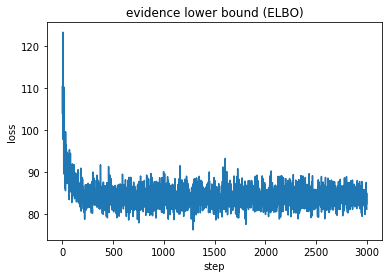

In [180]:
plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

### Visualisation for mocked documents

tensor([[0.3107, 1.4786, 0.1252, 0.0000],
        [1.3551, 0.0473, 0.0178, 0.0000],
        [0.0529, 0.0130, 1.3553, 0.0000]], dtype=torch.float64)


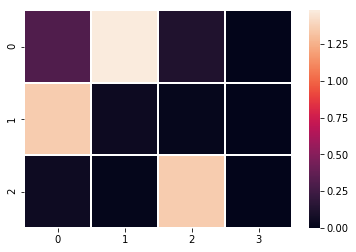

In [181]:
def visualise_topics():
    docs_topics=[]
    for d in range(D):
        values=dist.Dirichlet(pyro.param("alpha_q_%d"%d)).sample().tolist()
        values_normalized=(values-np.min(values))/(np.max(values)-np.mean(values))
        docs_topics.append(values_normalized)
    print(torch.tensor(docs_topics))
    sns.heatmap(docs_topics,linewidths=.9)
    
visualise_topics()

In [182]:
words_per_topics=dist.Dirichlet(pyro.param('beta_q')).sample()
print(words_per_topics)

tensor([[2.4676e-01, 2.8730e-02, 3.8808e-02, 6.1675e-02, 1.1349e-01, 4.7860e-03,
         1.4567e-02, 2.5309e-04, 2.1074e-01, 6.7003e-02, 4.8664e-02, 8.7835e-02,
         7.6690e-02],
        [9.0837e-03, 2.5055e-02, 1.4851e-01, 4.1678e-02, 7.2338e-02, 9.6847e-02,
         6.1630e-02, 6.1930e-02, 3.1233e-03, 2.2293e-01, 1.1948e-01, 1.1817e-01,
         1.9236e-02],
        [2.7195e-02, 3.6004e-02, 1.5518e-01, 2.2994e-02, 6.9416e-02, 3.3828e-01,
         9.1996e-03, 3.2167e-02, 1.8495e-01, 5.7952e-02, 3.4447e-02, 1.2034e-02,
         2.0188e-02],
        [8.8098e-03, 1.6775e-01, 1.7418e-01, 1.5849e-01, 1.6257e-02, 2.0113e-02,
         6.9770e-02, 5.2455e-02, 4.5112e-02, 8.3574e-02, 8.8533e-02, 7.2206e-02,
         4.2744e-02]])


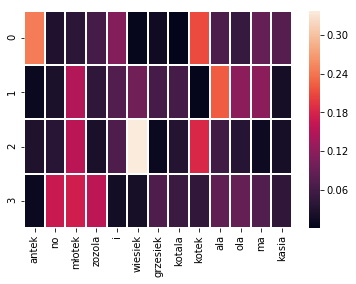

In [183]:
sns.heatmap(words_per_topics,linewidths=.9,xticklabels=VOCABULARY_DICT.keys())


### Model for documents derived from CLARIN-PL webpage

In [5]:
dictionary=None
with codecs.open("2autorow/prus_lalka.txt",'r','cp1250') as f:
    cn = Counter(word.strip(punctuation) for line in f for word in line.lower().split())
    dictionary=dict((word,v )for word,v in cn.items() if v > 200 )
    

In [186]:
regex = re.compile('[^a-zA-Z\s]')


def prepare_clarin_data_v1():
    file_names=['2autorow/prus_lalka.txt','2autorow/prus_faraon.txt','2autorow/reymont_komediantka.txt','2autorow/reymont_fermenty.txt']
    docs=[]
    docs_l=[]
    for file in file_names:
        dictionary=None
        with codecs.open(file,'r','cp1250') as f:
            cn = Counter(word.strip(punctuation) for line in f for word in line.lower().split())
            dictionary=dict((word,v )for word,v in cn.items() if v > 50 )
        doc_l=list(dictionary.keys())
        doc=np.asarray(doc_l)
        docs.append(doc)
        docs_l.append(doc_l)
    N=[len(i) for i in docs_l]
    N=np.asarray(N)
    #VOCABULARY
    flatten_data=flat_list = [item for sublist in docs_l for item in sublist]
    VOCABULARY=list(set(flatten_data))
    V=len(VOCABULARY)
    indexes=[i for i in range(V)]
    VOCABULARY_DICT = dict(zip(VOCABULARY, indexes))
    docs=np.asarray(docs)
    D=4
    for i in range(D):
        doc=docs_l[i]
        new_doc=[VOCABULARY_DICT[word] for word in doc]
        docs[i]=torch.tensor(new_doc)
    return docs, VOCABULARY, VOCABULARY_DICT,V,N,D
    

In [187]:
data, VOCABULARY, VOCABULARY_DICT,V,N,D=prepare_clarin_data_v1()
K=8

In [189]:
print(VOCABULARY)

['', 'swej', 'twarz', 'rozumie', 'też', 'gdybym', 'arcykapłan', 'nowe', 'patrząc', 'jedna', 'scenie', 'razy', 'książę', 'i', 'wszystkim', 'jeżeli', 'tej', 'jesteś', 'odpowiedział', 'zawsze', 'mego', 'właśnie', 'bogom', 'ludzie', 'mieć', 'teatr', 'drzwi', 'stary', 'żołnierzy', 'teraz', 'janka', 'każdym', 'jej', 'ale', 'takie', 'maruszewicz', 'temu', 'dosyć', 'rzekł', 'około', 'siedział', 'teatru', 'przez', 'pani', 'hrabia', 'widać', 'wtrącił', 'warszawy', 'kilku', 'las', 'którzy', 'przepraszam', 'pieniądze', 'innym', 'takiego', 'świata', 'barona', 'twój', 'labiryntu', 'was', 'interes', 'prawo', 'czego', 'uśmiechem', 'wielką', 'powiem', 'sama', 'miejsce', 'powiedzieć', 'siebie', 'kobiety', 'tych', 'izabela', 'sceny', 'jego', 'rok', 'ziemię', 'doktor', 'widzi', 'cały', 'faraon', 'adwokat', 'dzieci', 'że', 'będziesz', 'chłopów', 'ta', 'wcale', 'zawołał', 'chyba', 'zaleska', 'było', 'państwo', 'strony', 'o', 'je', 'obok', 'wojska', 'pannę', 'głową', 'ręce', 'bym', 'niż', 'stara', 'panną', '

In [190]:
def model(data):
  phi = pyro.sample("phi",dist.Dirichlet(torch.ones([K, V]),validate_args=False).independent(1))
  for d in pyro.irange("documents", D):
    theta_d = pyro.sample("theta_%d"%d, dist.Dirichlet(torch.ones([K]),validate_args=False))
    
    with pyro.iarange("words_%d"%d, N[d]):
      z = pyro.sample("z_%d"%d, dist.Categorical(theta_d))
      pyro.sample("w_%d"%d, dist.Categorical(phi[z]), obs=data[d])
        
def guide(data):
  beta_q = pyro.param("beta_q", torch.ones([K, V]),constraint=constraints.positive)
  phi_q = pyro.sample("phi",dist.Dirichlet(beta_q,validate_args=False).independent(1))
  for d in pyro.irange("documents", D):
    alpha_q = pyro.param("alpha_q_%d"%d, torch.ones([K]),constraint=constraints.positive)
    q_theta_d = pyro.sample("theta_%d"%d, dist.Dirichlet(alpha_q,validate_args=False))
    
    with pyro.iarange("words_%d"%d, N[d]):
      q_i = pyro.param("q_%d"%d, torch.randn([N[d], K]).exp(),
                       constraint=constraints.simplex)
      pyro.sample("z_%d"%d, dist.Categorical(q_i))
        
losses=[]
def train():
    pyro.clear_param_store()
    num_iterations=400
    optim = pyro.optim.Adam({"lr": 0.1})
    svi = SVI(model, config_enumerate(guide, 'parallel'), optim, loss=TraceEnum_ELBO(max_iarange_nesting=1))
    t=tqdm(range(num_iterations))
    for j in t:
        loss = svi.step(data)
        t.set_postfix(loss=loss)
        losses.append(loss)
    return (model, svi)

In [191]:
train()

(<function __main__.model(data)>, <pyro.infer.svi.SVI at 0x7efcd3726630>)

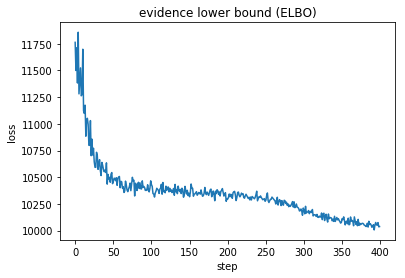

In [192]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

tensor([[1.2440e+00, 1.1435e-02, 1.1354e-01, 2.3026e-01, 4.8213e-02, 2.3614e-01,
         0.0000e+00, 6.8243e-02],
        [1.8022e-02, 0.0000e+00, 5.2975e-03, 1.3860e-02, 6.4375e-04, 1.1510e+00,
         1.3795e-02, 5.6238e-03],
        [4.0266e-03, 8.6271e-04, 7.8511e-03, 4.0734e-03, 9.1221e-03, 1.1477e+00,
         8.1090e-03, 0.0000e+00],
        [0.0000e+00, 9.9376e-03, 4.3538e-03, 2.6336e-03, 7.0068e-03, 1.1484e+00,
         6.7890e-03, 8.2496e-03]], dtype=torch.float64)


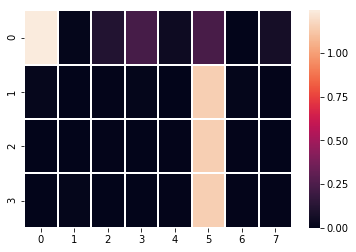

In [193]:
visualise_topics()

tensor([[5.8091e-04, 3.1552e-04, 8.6210e-04,  ..., 1.9456e-03, 6.9940e-04,
         2.0934e-03],
        [3.1963e-06, 4.0802e-05, 2.3477e-05,  ..., 5.3030e-04, 3.0762e-03,
         9.9208e-04],
        [1.4648e-03, 1.3714e-03, 2.1264e-04,  ..., 2.1444e-03, 1.5739e-03,
         1.2671e-04],
        ...,
        [1.1581e-03, 3.1056e-03, 2.6932e-03,  ..., 4.1007e-03, 2.7908e-03,
         2.6197e-04],
        [1.0306e-04, 2.7236e-04, 1.0175e-03,  ..., 1.2645e-04, 1.8241e-05,
         2.8388e-03],
        [5.5167e-04, 4.7048e-04, 2.2460e-03,  ..., 6.9216e-04, 7.1159e-03,
         2.2059e-03]])


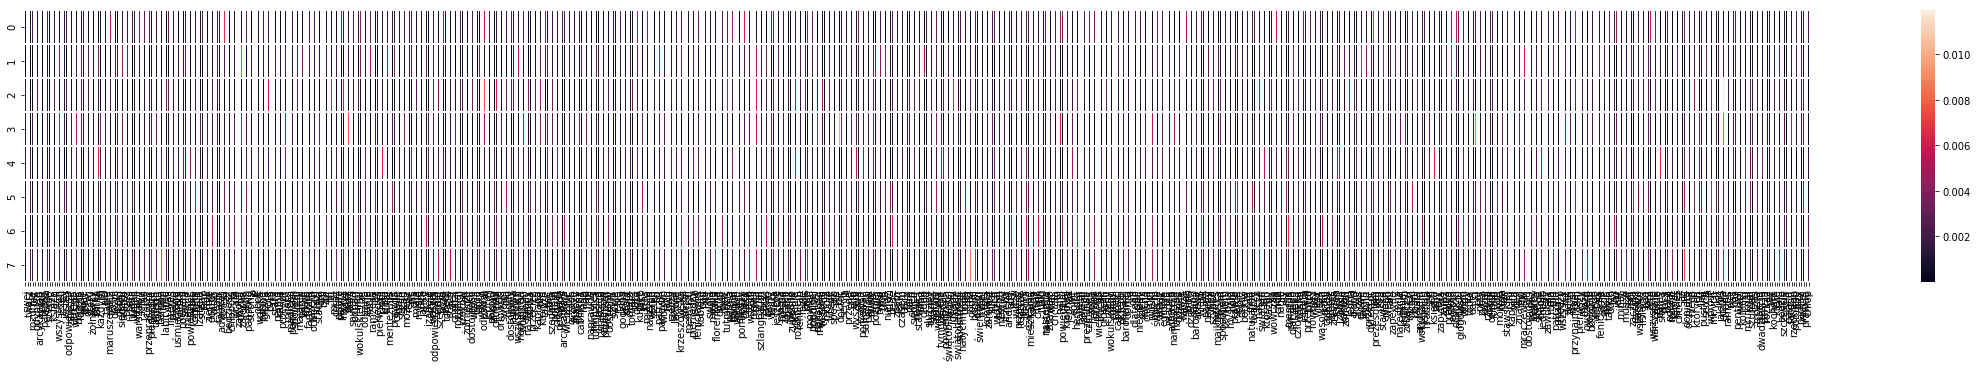

In [195]:
words_per_topics=dist.Dirichlet(pyro.param('beta_q')).sample()
print(words_per_topics)
fig, ax = plt.subplots(figsize=(40,5))  
sns.heatmap(words_per_topics,linewidths=.9,xticklabels=VOCABULARY_DICT.keys(),ax=ax)

In [196]:
def show_words_in_topic(topic):
    values=words_per_topics[topic].tolist()
    keys=list(VOCABULARY_DICT.keys())
    zipped=dict(zip(keys,values))
#     sorted_dict = collections.OrderedDict(zipped)
    sorted_dict=sorted(zipped.items(), key=lambda x: x[1], reverse=True)
    print(sorted_dict)

In [208]:
show_words_in_topic(2)

[('czuła', 0.011951685883104801), ('odezwał', 0.007739577908068895), ('ależ', 0.007540345657616854), ('zresztą', 0.006455118302255869), ('dnia', 0.006253275088965893), ('króla', 0.0062331524677574635), ('chociaż', 0.00604664534330368), ('tu', 0.006035483907908201), ('ignacy', 0.005929808132350445), ('bo', 0.0059118252247571945), ('ręce', 0.005562653299421072), ('tutmozis', 0.005519491154700518), ('mogę', 0.0053217969834804535), ('tych', 0.0052594407461583614), ('spytał', 0.00515011278912425), ('siebie', 0.005033215973526239), ('które', 0.004838890861719847), ('mądrość', 0.004711429122835398), ('pustyni', 0.004692979156970978), ('teraz', 0.0046239919029176235), ('mu', 0.004623980727046728), ('dla', 0.004541929345577955), ('wtrącił', 0.004491107072681189), ('kobietę', 0.004489576444029808), ('drugi', 0.004396183881908655), ('sklepie', 0.004389923997223377), ('wczoraj', 0.004347905050963163), ('sklepu', 0.004244367126375437), ('dwu', 0.0041856830939650536), ('fotelu', 0.004155287984758615

### 